# 순환 신경망의 고급 사용법

## 기온 예측 문제

In [1]:
## 날씨 데이터세트 조사

import os

data_dir = './datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(lines[0])
print(lines[1])
print(lines[2])
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
420551


In [2]:
## 날씨 데이터 파싱

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

print(float_data)

[[ 9.9652e+02 -8.0200e+00  2.6540e+02 ...  1.0300e+00  1.7500e+00
   1.5230e+02]
 [ 9.9657e+02 -8.4100e+00  2.6501e+02 ...  7.2000e-01  1.5000e+00
   1.3610e+02]
 [ 9.9653e+02 -8.5100e+00  2.6491e+02 ...  1.9000e-01  6.3000e-01
   1.7160e+02]
 ...
 [ 9.9982e+02 -3.1600e+00  2.7001e+02 ...  1.0800e+00  2.0000e+00
   2.1520e+02]
 [ 9.9981e+02 -4.2300e+00  2.6894e+02 ...  1.4900e+00  2.1600e+00
   2.2580e+02]
 [ 9.9982e+02 -4.8200e+00  2.6836e+02 ...  1.2300e+00  1.9600e+00
   1.8490e+02]]


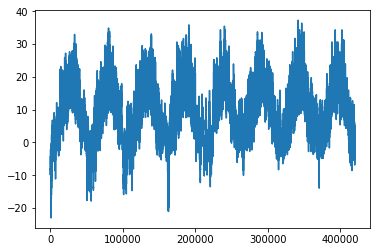

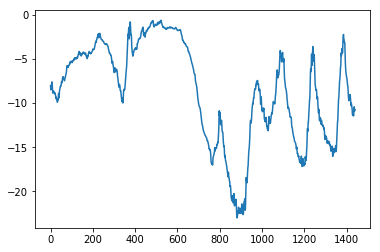

In [3]:
## 시계열차트 표현

%matplotlib inline
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 썹씨온도
plt.plot(range(len(temp)), temp)  # 전체시간
plt.figure()
plt.plot(range(1440), temp[:1440])  # 10분*1440 = 10단위*24시간 = 10일

In [4]:
## 데이터 정규화

mean = float_data[:200000].mean(axis=0)
float_data -= mean  # 전체데이터에 평균 차감
std = float_data[:200000].std(axis=0)
float_data /= std  # 전체데이터에 표준편차 나눔

In [5]:
## 시계열데이터와 타깃을 반환하는 제너레이터 함수

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    if max_index is None:  # 나머지 최대경계 설정
        max_index = len(data) - delay - 1
    
    i = min_index + lookback  # 시작경계 설정
    
    while 1:
        if shuffle:  # 배치단위 랜덤 인덱스배열 생성 (셔플용)
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:  # 배치단위 순차 인덱스배열 생성
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1],))  # 인덱스배열 차원 + 시간단위 차원 + 속성 차원
        targets = np.zeros((len(rows),))  # 인덱스배열 차원
        
        for j, row in enumerate(rows):  # 인덱스배열에서 할당된 각 인덱스별로 데이터채우기
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [6]:
## 훈련,검증,테스트 데이터세트 준비

lookback = 1440  # 과거 타임스텝 (1440스텝 == 14400분 == 10일)
delay = 144  # 미래 타임스텝 (144스텝 == 1440분 == 1일)
step = 6  # 시퀀스 샘플링 단위 (1시간단위 샘플링; 시퀀스 하나당 10분단위이므로)
batch_size = 128  # 배치 단위

train_gen = generator(float_data, min_index=0, max_index=200000, step=step, batch_size=batch_size,
                       lookback=lookback, delay=delay, shuffle=True)

val_gen = generator(float_data, min_index=200001, max_index=300000, step=step, batch_size=batch_size,
                       lookback=lookback, delay=delay, shuffle=False)

test_gen = generator(float_data, min_index=300001, max_index=None, step=step, batch_size=batch_size,
                       lookback=lookback, delay=delay, shuffle=False)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [7]:
## 상식적인 기준 모델 MAE 계산

def evaluate_native_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)  # 정규화된 데이터에서 검증값 생성
        preds = samples[:, -1, 1]  # 직전 24시간전 온도속성을 예측값으로 판단
        mae = np.mean(np.abs(preds - targets))  # 평균절대값오차 계산 (오차의 절대값 평균, 예측과 얼마나 벗어났는가)
        batch_maes.append(mae)
        
    return np.mean(batch_maes)  # 모든 평균절대값오차들의 평균 (예측과 얼마나 벗어났는지에 대한 평균)


native_mae = evaluate_native_method()  # 상식수준 예측값 (다음 온도값이 직전 24시간전 온도값에서 얼마나 벗어났는가)
print(native_mae)

celsius_mae = native_mae * std[1]  # 상식수준 예측값을 썹시온도로 변환 (원본 온도값이 평균0 표준편차1 이므로, ~~~)
print(celsius_mae)

0.2897359729905486
2.564887434980494


In [8]:
## 완전연결모델 훈련 및 평가

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 0.7110 - val_loss: 0.3628
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3050 - val_loss: 0.3022
Epoch 3/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2724 - val_loss: 0.3270
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2572 - val_loss: 0.3178
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2476 - val_loss: 0.3136
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2406 - val_loss: 0.3095
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2356 - val_loss: 0.3337
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2311 - val_loss: 0.3140
Epoch 9/20
500/500 [==============================] - 14s 28ms/s

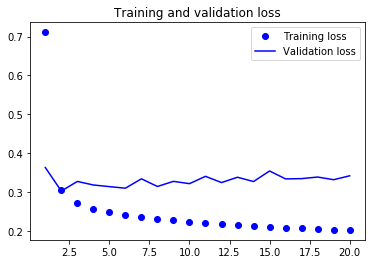

In [9]:
## 시계열차트 표현

%matplotlib inline
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/20
500/500 [==============================] - 101s 202ms/step - loss: 0.3143 - val_loss: 0.2712
Epoch 2/20
500/500 [==============================] - 104s 208ms/step - loss: 0.2842 - val_loss: 0.2681
Epoch 3/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2755 - val_loss: 0.2614
Epoch 4/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2709 - val_loss: 0.2643
Epoch 5/20
500/500 [==============================] - 120s 240ms/step - loss: 0.2672 - val_loss: 0.2643
Epoch 6/20
500/500 [==============================] - 120s 239ms/step - loss: 0.2593 - val_loss: 0.2632
Epoch 7/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2590 - val_loss: 0.2646
Epoch 8/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2529 - val_loss: 0.2671
Epoch 9/20
500/500 [==============================] - 118s 235ms/step - loss: 0.2476 - val_loss: 0.2715
Epoch 10/20
500/500 [==============================] - 123s 246m

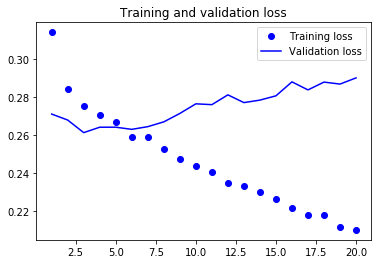

In [10]:
## GRU 기반 모델 훈련 및 평가

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 152s 304ms/step - loss: 0.3366 - val_loss: 0.2768
Epoch 2/40
500/500 [==============================] - 128s 256ms/step - loss: 0.3177 - val_loss: 0.2749
Epoch 3/40
500/500 [==============================] - 132s 265ms/step - loss: 0.3084 - val_loss: 0.2817
Epoch 4/40
500/500 [==============================] - 154s 308ms/step - loss: 0.3036 - val_loss: 0.2699
Epoch 5/40
500/500 [==============================] - 146s 293ms/step - loss: 0.3039 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 193s 386ms/step - loss: 0.3012 - val_loss: 0.2672
Epoch 7/40
500/500 [==============================] - 176s 352ms/step - loss: 0.2963 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 119s 239ms/step - loss: 0.2945 - val_loss: 0.2748
Epoch 9/40
500/500 [==============================] -

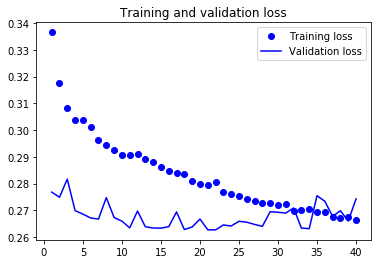

In [11]:
## 드롭아웃 + GRU 모델 훈련 및 평가


model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,  # 드롭아웃 적용
                     recurrent_dropout=0.2,  # 순환드롭아웃 적용
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,  # 에포크 증가
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/40
500/500 [==============================] - 308s 616ms/step - loss: 0.3370 - val_loss: 0.2796
Epoch 2/40
500/500 [==============================] - 320s 641ms/step - loss: 0.3143 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 325s 650ms/step - loss: 0.3045 - val_loss: 0.2727
Epoch 4/40
500/500 [==============================] - 326s 652ms/step - loss: 0.3007 - val_loss: 0.2684
Epoch 5/40
500/500 [==============================] - 327s 653ms/step - loss: 0.2985 - val_loss: 0.2699
Epoch 6/40
500/500 [==============================] - 328s 655ms/step - loss: 0.2931 - val_loss: 0.2663
Epoch 7/40
500/500 [==============================] - 328s 656ms/step - loss: 0.2902 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 329s 659ms/step - loss: 0.2861 - val_loss: 0.2648
Epoch 9/40
500/500 [==============================] - 327s 654ms/step - loss: 0.2835 - val_loss: 0.2677
Epoch 10/40
500/500 [==============================] - 328s 655m

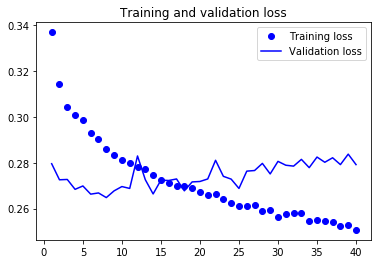

In [13]:
## 드롭아웃 + 스태킹 + GRU 모델 훈련 및 평가


model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,  # 스태킹 적용
                     input_shape=(None, float_data.shape[-1])
                    )
         )
model.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.5, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()